In [ ]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
import json
from sklearn.compose import TransformedTargetRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from utils import BikeDemandDataProcessor


# Set style
plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [ ]:
lambda_ = None

def func(x):
    global lambda_
    x = np.ravel(x)
    transformed, lambda_ = boxcox(x + 1)
    return transformed.reshape(-1, 1)

def inverse_func(x):
    global lambda_
    x = np.ravel(x)
    if lambda_ is None:
        raise ValueError("Lambda is not set. Call func() first.")
    if lambda_ == 0:
        return (np.exp(x) - 1).reshape(-1, 1)
    else:
        return ((x * lambda_ + 1) ** (1 / lambda_) - 1).reshape(-1, 1)

In [56]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("data/hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)

Loading data from C:\Users\Lawrence\Documents\PYTHON\bike_demand_2025/data/hour.csv


This time using full training data and the unseen test_df

In [57]:
train_df, val_df = processor.split_and_engineer_data(hour_processed_df)

In [58]:
train_df, val_df = processor.split_and_engineer_data(hour_processed_df)

## Baseline with no feature Engineering

In [59]:
target = 'count'

original_features = ['day', 'season', 'year', 'month', 'hour', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 
                   'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'hum_windspeed', 
                   'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 
                   'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 
                   'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 
                   'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'moonphase']

categorical_label_encode_columns = ['hour', 'year', 'day', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'working_day', 'weekend', 
                                    'is_monday', 'is_friday', 'christmas_holiday_season', 
                                    'summer_season', 'spring_season', 'fall_season', 'winter_season', 'is_night', 'rush_hour', 'is_business_hours', 'sigma_3_outlier']

categorical_one_hot_columns = ['quarter', 'day_of_week']

numeric_columns = [col for col in numeric_columns if col in original_features]
categorical_label_encode_columns = [col for col in categorical_label_encode_columns if col in original_features]
categorical_one_hot_columns = [col for col in categorical_one_hot_columns if col in original_features]

features = numeric_columns + categorical_label_encode_columns + categorical_one_hot_columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns)  # Add one-hot encoding here
    ],
    remainder='drop',
    n_jobs=-1
)

with open('best_lgbm_params.json', 'r') as file:
    params = json.load(file)

lgbm_regressor_baseline = lgb.LGBMRegressor(verbosity=-1)

lgbm_regressor_tuned = lgb.LGBMRegressor(**params, verbosity=-1)

baseline_transformed_regressor = TransformedTargetRegressor(
    regressor=lgbm_regressor_baseline,
    func=func,
    inverse_func=inverse_func
)

tuned_transformed_regressor = TransformedTargetRegressor(
    regressor=lgbm_regressor_tuned,
    func=func,
    inverse_func=inverse_func
)

baseline_regressor = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", baseline_transformed_regressor)
])

In [60]:
X_train = train_df[features]
y_train = train_df[target]

baseline_regressor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('cat_label',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['hour', 'year', 'day',
                                                   'season', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit']),
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor',
                 TransformedTargetRegressor(func=<function func at 0x000001DFC79D3A60>,
                                            inverse_func=<function inverse_func at 0x000001DFC7170360>,
                                            regressor=LGBMRegressor(verbosity=-1)))])

In [61]:
X_val = val_df[features]
y_val = val_df[target]
y_pred = baseline_regressor.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

logging.info(f"RMSE: {rmse}")

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-03-11 18:40:11,775 - INFO - RMSE: 65.26069866814498


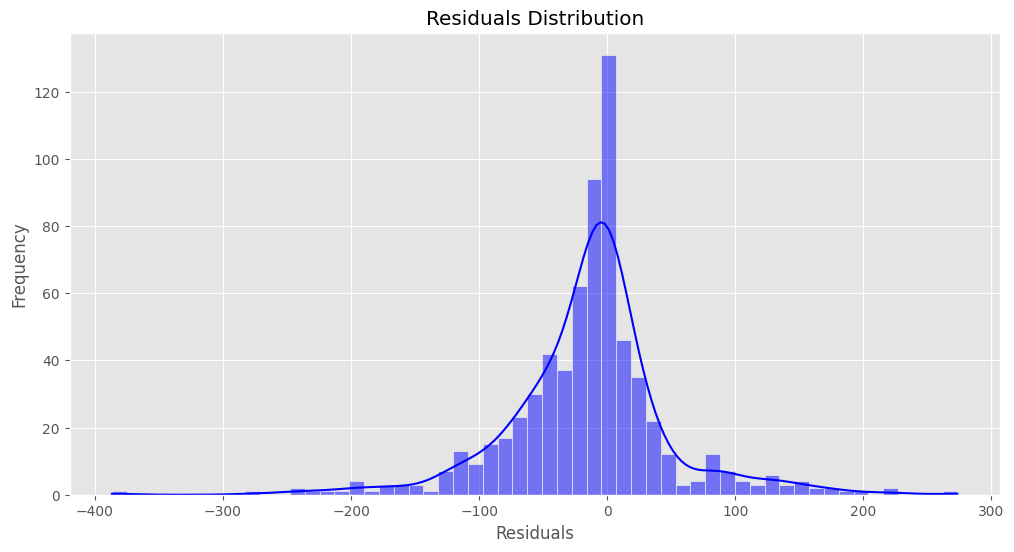

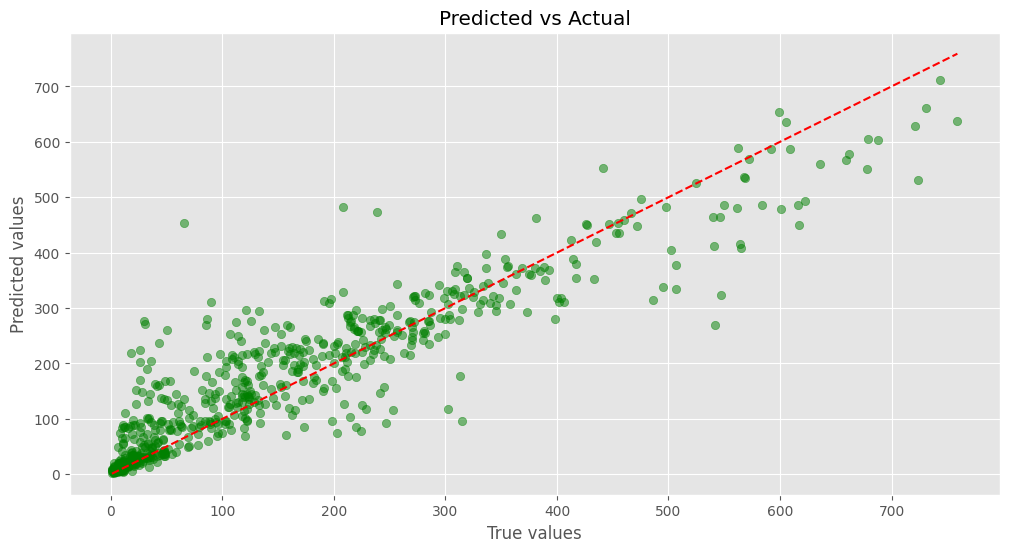

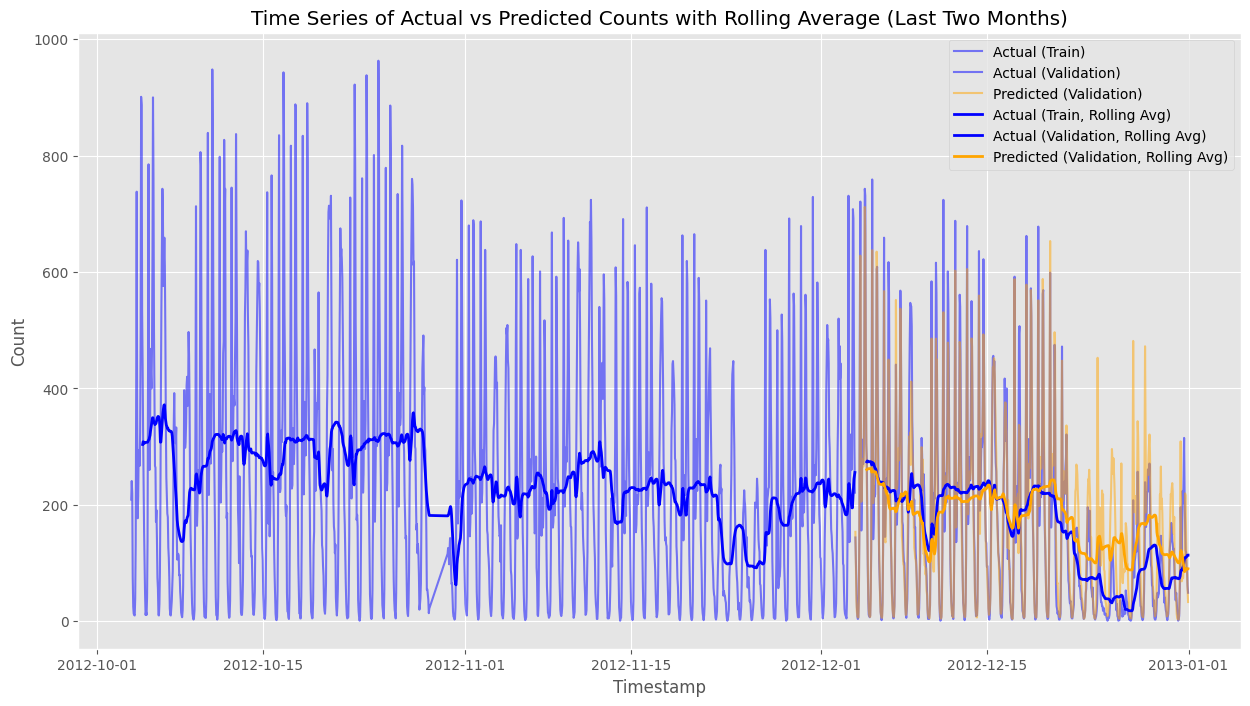

In [62]:
# Filter the last two months of data
last_two_months_train = train_df[train_df['timestamp'] >= train_df['timestamp'].max() - pd.DateOffset(months=2)]
last_two_months_val = val_df[val_df['timestamp'] >= val_df['timestamp'].max() - pd.DateOffset(months=2)]

residuals = y_val - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(last_two_months_train['timestamp'], last_two_months_train[target], label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(last_two_months_val['timestamp'], last_two_months_val[target], label='Actual (Validation)', color='blue', alpha=0.5)
plt.plot(last_two_months_val['timestamp'], y_pred[-len(last_two_months_val):], label='Predicted (Validation)', color='orange', alpha=0.5)
plt.plot(last_two_months_train['timestamp'], last_two_months_train[target].rolling(window=24).mean(), label='Actual (Train, Rolling Avg)', color='blue', linewidth=2)
plt.plot(last_two_months_val['timestamp'], last_two_months_val[target].rolling(window=24).mean(), label='Actual (Validation, Rolling Avg)', color='blue', linewidth=2)
plt.plot(last_two_months_val['timestamp'], pd.Series(y_pred[-len(last_two_months_val):]).rolling(window=24).mean(), label='Predicted (Validation, Rolling Avg)', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Time Series of Actual vs Predicted Counts with Rolling Average (Last Two Months)')
plt.legend()
plt.show()


## Feature Engineering, Feature Reduction and Hyperparameter Tuning 

In [63]:
target = 'count'

with open('best_features_list.json', 'r') as f:
    features_from_rfe_selection = json.load(f)

numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 
                   'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'hum_windspeed', 
                   'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 
                   'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 
                   'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 
                   'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'moonphase']

categorical_label_encode_columns = ['hour', 'year', 'day', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'working_day', 'weekend', 
                                    'is_monday', 'is_friday', 'christmas_holiday_season', 
                                    'summer_season', 'spring_season', 'fall_season', 'winter_season', 'is_night', 'rush_hour', 'is_business_hours', 'sigma_3_outlier']

categorical_one_hot_columns = ['quarter', 'day_of_week']

numeric_columns = [col for col in numeric_columns if col in features_from_rfe_selection]
categorical_label_encode_columns = [col for col in categorical_label_encode_columns if col in features_from_rfe_selection]
categorical_one_hot_columns = [col for col in categorical_one_hot_columns if col in features_from_rfe_selection]

features = numeric_columns + categorical_label_encode_columns + categorical_one_hot_columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns)  # Add one-hot encoding here
    ],
    remainder='drop',
    n_jobs=-1
)

with open('best_lgbm_params.json', 'r') as file:
    params = json.load(file)

lgbm_regressor_tuned = lgb.LGBMRegressor(**params, verbosity=-1)

tuned_transformed_regressor = TransformedTargetRegressor(
    regressor=lgbm_regressor_tuned,
    func=func,
    inverse_func=inverse_func
)

tuned_regressor = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", tuned_transformed_regressor)
])

In [64]:
X_train = train_df[features]
y_train = train_df[target]

tuned_regressor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'year_sin', 'hour_sin',
                                                   'hour_cos', 'week_cos',
                                                   'weather_hum',
                                                   'temp_atemp']),
                                                 ('cat_label',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_va...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor',
                 TransformedTargetRegressor(func=<function func at 0x000001DFC79D3A60>,
                                            inverse_func=<function inverse_func at 0x000001DFC7170360>,
                                            regressor=LGBMRegressor(colsample_bytree=0.55,
                                                                    learning_rate=0.08,
                                                                    max_depth=4,
                                                                    min_child_samples=48,
                                                                    n_estimators=200,
                                                                    num_leaves=90,
                                                                    reg_alpha=0.45,
                                                                    reg_lambda=0.4,
                                                                    subsample=0.75,
                                                                    verbosity=-1)))])

In [65]:
X_val = val_df[features]
y_val = val_df[target]
y_pred = tuned_regressor.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

logging.info(f"RMSE: {rmse}")

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-03-11 18:40:12,495 - INFO - RMSE: 59.210679046997996


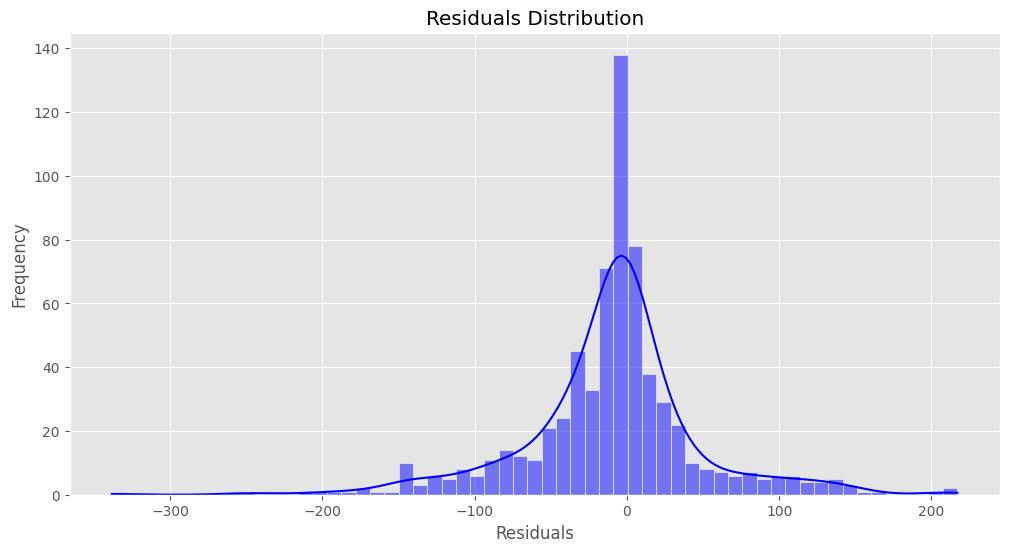

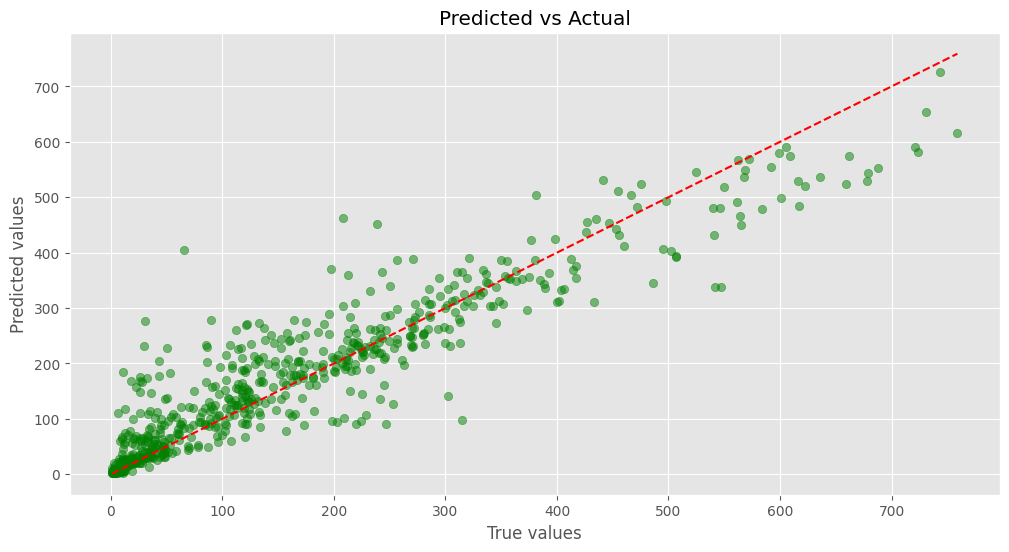

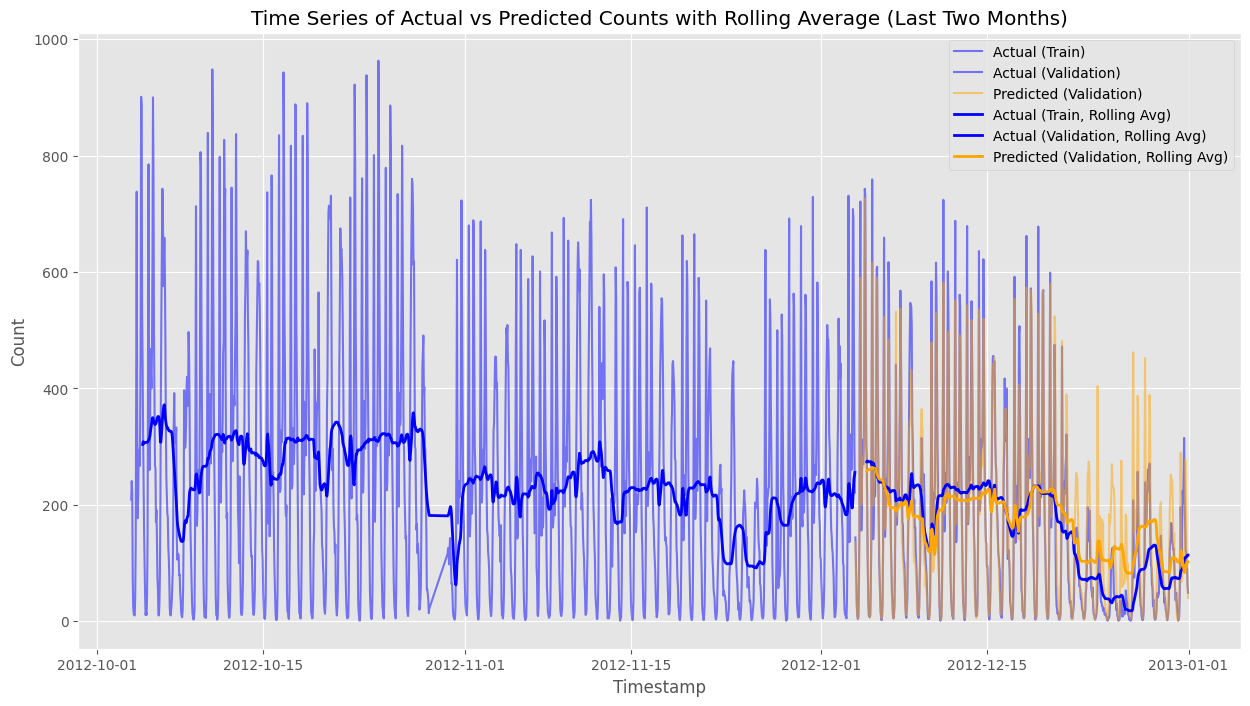

In [66]:
# Filter the last two months of data
last_two_months_train = train_df[train_df['timestamp'] >= train_df['timestamp'].max() - pd.DateOffset(months=2)]
last_two_months_val = val_df[val_df['timestamp'] >= val_df['timestamp'].max() - pd.DateOffset(months=2)]

residuals = y_val - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(last_two_months_train['timestamp'], last_two_months_train[target], label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(last_two_months_val['timestamp'], last_two_months_val[target], label='Actual (Validation)', color='blue', alpha=0.5)
plt.plot(last_two_months_val['timestamp'], y_pred[-len(last_two_months_val):], label='Predicted (Validation)', color='orange', alpha=0.5)
plt.plot(last_two_months_train['timestamp'], last_two_months_train[target].rolling(window=24).mean(), label='Actual (Train, Rolling Avg)', color='blue', linewidth=2)
plt.plot(last_two_months_val['timestamp'], last_two_months_val[target].rolling(window=24).mean(), label='Actual (Validation, Rolling Avg)', color='blue', linewidth=2)
plt.plot(last_two_months_val['timestamp'], pd.Series(y_pred[-len(last_two_months_val):]).rolling(window=24).mean(), label='Predicted (Validation, Rolling Avg)', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Time Series of Actual vs Predicted Counts with Rolling Average (Last Two Months)')
plt.legend()
plt.show()


## Catboost seems to beat LightGBM
- It seems to manage to recognise the chirstmas period a bit better

In [ ]:
target = 'count'

with open('best_features_list.json', 'r') as f:
    features_from_rfe_selection = json.load(f)

numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 
                   'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'hum_windspeed', 
                   'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 
                   'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 
                   'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 
                   'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'moonphase']

categorical_label_encode_columns = ['hour', 'year', 'day', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'working_day', 'weekend', 
                                    'is_monday', 'is_friday', 'christmas_holiday_season', 
                                    'summer_season', 'spring_season', 'fall_season', 'winter_season', 'is_night', 'rush_hour', 'is_business_hours', 'sigma_3_outlier']

categorical_one_hot_columns = ['quarter', 'day_of_week']

numeric_columns = [col for col in numeric_columns if col in features_from_rfe_selection]
categorical_label_encode_columns = [col for col in categorical_label_encode_columns if col in features_from_rfe_selection]
categorical_one_hot_columns = [col for col in categorical_one_hot_columns if col in features_from_rfe_selection]

features = numeric_columns + categorical_label_encode_columns + categorical_one_hot_columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns)  # Add one-hot encoding here
    ],
    remainder='drop',
    n_jobs=-1
)

catboost_regressor = CatBoostRegressor(verbose=0)

tuned_regressor = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", catboost_regressor)
])


In [68]:
X_train = train_df[features]
y_train = train_df[target]

tuned_regressor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'year_sin', 'hour_sin',
                                                   'hour_cos', 'week_cos',
                                                   'weather_hum',
                                                   'temp_atemp']),
                                                 ('cat_label',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['hour', 'day', 'season',
                                                   'weekday', 'workingday',
                                                   'working_day', 'is_night',
                                                   'rush_hour',
                                                   'is_business_hours']),
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x000001DFC78D3050>)])

In [69]:
X_val = val_df[features]
y_val = val_df[target]
y_pred = tuned_regressor.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

logging.info(f"RMSE: {rmse}")

2025-03-11 18:40:15,194 - INFO - RMSE: 57.456695441136084


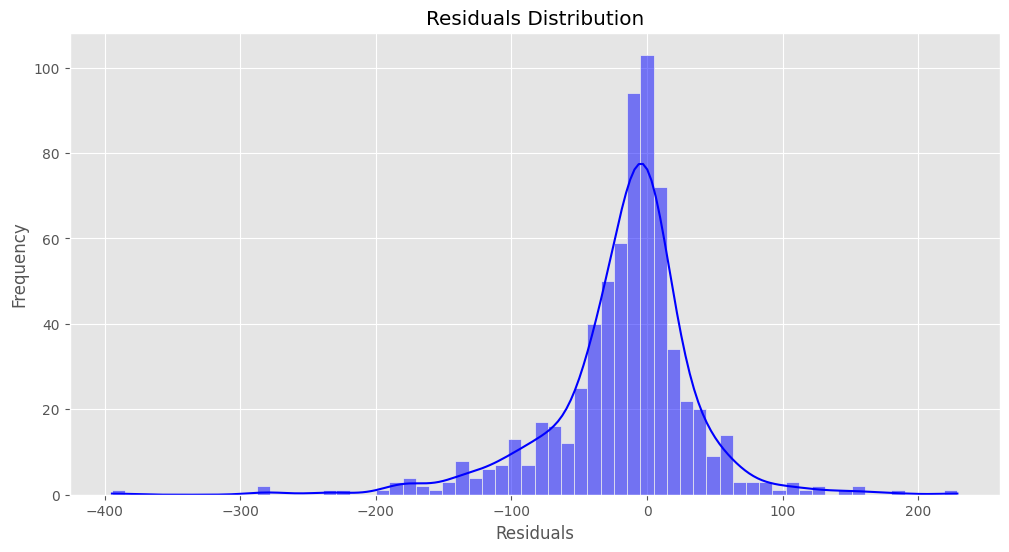

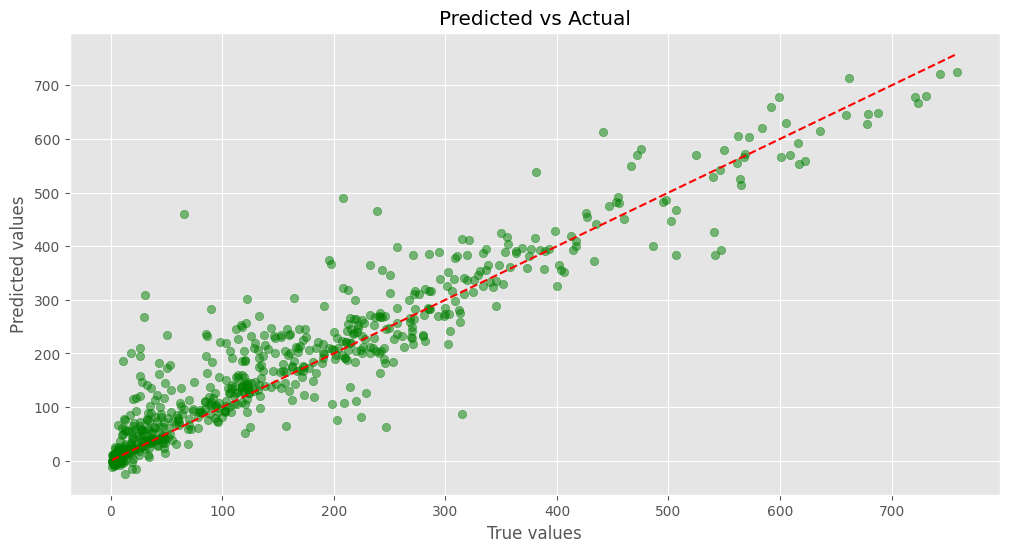

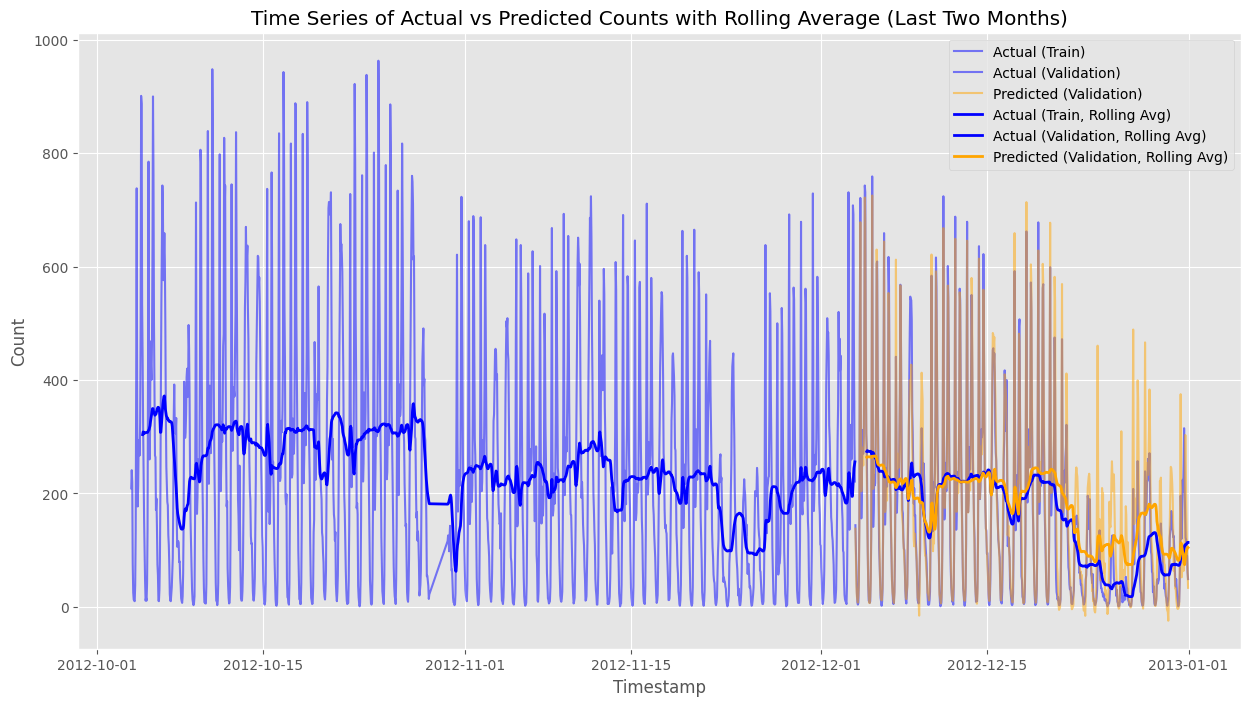

In [70]:
# Filter the last two months of data
last_two_months_train = train_df[train_df['timestamp'] >= train_df['timestamp'].max() - pd.DateOffset(months=2)]
last_two_months_val = val_df[val_df['timestamp'] >= val_df['timestamp'].max() - pd.DateOffset(months=2)]

residuals = y_val - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(last_two_months_train['timestamp'], last_two_months_train[target], label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(last_two_months_val['timestamp'], last_two_months_val[target], label='Actual (Validation)', color='blue', alpha=0.5)
plt.plot(last_two_months_val['timestamp'], y_pred[-len(last_two_months_val):], label='Predicted (Validation)', color='orange', alpha=0.5)
plt.plot(last_two_months_train['timestamp'], last_two_months_train[target].rolling(window=24).mean(), label='Actual (Train, Rolling Avg)', color='blue', linewidth=2)
plt.plot(last_two_months_val['timestamp'], last_two_months_val[target].rolling(window=24).mean(), label='Actual (Validation, Rolling Avg)', color='blue', linewidth=2)
plt.plot(last_two_months_val['timestamp'], pd.Series(y_pred[-len(last_two_months_val):]).rolling(window=24).mean(), label='Predicted (Validation, Rolling Avg)', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Time Series of Actual vs Predicted Counts with Rolling Average (Last Two Months)')
plt.legend()
plt.show()
